#Description
This data wrangling will be broken up into many parts.
1. PCPAO_SalesDATA

*   Import Data
*   Drop data that isn't single-family home(or condos in the future).
*   Convert sales_date into datetime type
*   Limit data to most recent sale of each property
*   Drop repeated address data and owner names
*   Frontage, View, Landsize, Acreage, and QU_FLG are dropped
*   House Features are cleaned and converted to categories
*   County Designations are converted to categories or dropped
*   Subdivisions are examined and dropped
*   Examining dataset and dropping rows with missing values
*   Dropping Parcel Number and Site Address Columns
*   Converting Site_Cityzip and remaining object columns to categories
*   Dropping sales data prior to 1970
*   Making a dataframe of 2016-to-present sales

Future steps will be done to this data set involve its pairing with the data sets below.

2. PinellasCrimeDATA

This data is a collection of csv files downloaded from [Pinellas Crime Viewer](https://egis.pinellas.gov/apps/CrimeViewer/). The goal with this data is to generate totals and average yearly crime stats relative to each ZIP code and possibly neighborhood code.

3. School_gradeDATA

This data is yet to be collected from the FL DOE website.


[4. Export the data](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=AyfXeiJD1ZZ7&line=1&uniqifier=1)

####CHANGES TO MAKE
* In PCPAO_SalesDATA, keep the STR_CITY and STR_ZIP columns, drop the SITE_CITYZIP instead.
* IN PCPAO_SalesDATA, make the STR_CITY and STR_ZIP into Category datatypes.
* IN crime_data, when going to add new data from 2016 to 2020, separate the cleaning process? You will have done the 2020-2024 cleaning. Don't know how that might mess up the 2016-2020 data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#1. PCPAO_SalesDATA


###Importing Data

Import the data from the csv.

In [ ]:
PCPAO_SalesDATA = pd.read_csv('/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PCPAOSalesDATA.csv',low_memory=False)

In [ ]:
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155164 entries, 0 to 1155163
Data columns (total 54 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   PARCEL_NUMBER        1155164 non-null  object 
 1   OWNER1               1155134 non-null  object 
 2   OWNER2               624705 non-null   object 
 3   SITE_ADDRESS         1155160 non-null  object 
 4   SITE_CITYZIP         1155164 non-null  object 
 5   SUBDIVISION          1147546 non-null  object 
 6   LAND_SIZE            760559 non-null   object 
 7   TOTAL_LIVING_SQFT    1155156 non-null  float64
 8   TOTAL_GROSS_SQFT     1155156 non-null  float64
 9   NBORHOOD_CD          1155164 non-null  float64
 10  YEAR_BUILT_BLD1      1155098 non-null  float64
 11  TOTAL_LIVING_UNITS   1155156 non-null  float64
 12  ACREAGE              1155164 non-null  float64
 13  CNTY_JST_VALUE       1155164 non-null  int64  
 14  CNTY_ASD_VALUE       1155164 non-null  int64  
 15

###Dropping data that isn't about '0110 Single Family Home's.

Since all of the data is '0110 Single Family Home', dropping the PROPERTY_USE and PARCEL_TYPE columns.

In [ ]:
PCPAO_SalesDATA = PCPAO_SalesDATA[PCPAO_SalesDATA['PROPERTY_USE'] == '0110 Single Family Home']
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['PROPERTY_USE','PARCEL_TYPE'],axis=1)

###Converting the SALES_DATE to a datetime data type.

In [ ]:
PCPAO_SalesDATA['SALES_DATE'] = pd.to_datetime(PCPAO_SalesDATA['SALES_DATE'],format='%m/%d/%Y %I:%M:%S %p')


###Limiting the data to the most recent sale of each Parcel

I want to keep the sales data for only the most recent sale of each property.

In [ ]:
PCPAO_SalesDATA.sort_values(by='SALES_DATE',inplace=True)
PCPAO_SalesDATA.drop_duplicates(subset='PARCEL_NUMBER',keep='last',inplace=True)
PCPAO_SalesDATA.reset_index(drop=True,inplace=True)

In [ ]:
PCPAO_SalesDATA.head().T

,0,1,2,3,4
PARCEL_NUMBER,05-31-16-46116-020-0030,13-31-16-72504-001-0160,28-31-16-67338-026-0130,19-30-15-99342-006-0110,36-27-15-89334-000-0090
OWNER1,"PENTTINEN, GERALDINE L","VOGT, RONALD CHARLES","COONEY, ANN SHAW","BRUSKO, RYAN DAVID","LYON, YVONNE EYNON TRE"
OWNER2,NaN,"VOGT, TINA MARIE",NaN,NaN,"LYON, MARLENE ADELE TRE"
SITE_ADDRESS,6146 51ST AVE N,737 11TH ST N,5521 20TH AVE S,14066 STARBOARD DR,3025 LEPRECHAUN LN
SITE_CITYZIP,"KENNETH CITY, FL 33709","ST PETERSBURG, FL 33705","GULFPORT, FL 33707","SEMINOLE, FL 33776","PALM HARBOR, FL 34683"
SUBDIVISION,KENNETH CITY UNIT 7,"POMEROY'S ADD, J.B.",PASADENA GARDENS GULFVIEW SEC,YACHT CLUB ESTATES UNIT 6,TAMPA & TARPON SPRINGS LAND CO
LAND_SIZE,75x100,40x125,100x127,82x105,0x0
TOTAL_LIVING_SQFT,1281.0,920.0,768.0,1658.0,2721.0
TOTAL_GROSS_SQFT,2403.0,1238.0,1514.0,2180.0,3519.0
NBORHOOD_CD,407.0,1106.0,1304.0,608.0,1914.0


###Dropping repeated address information and owner names

From previous exploration, SITE_ADDRESS and SITE_CITYZIP matchup well enough with all of the STR_PFX, STR_NUM, STR_NAME, STR_SFX, STR_SFX_DIR, STR_CITY, and STR_ZIP, that I will drop all of the address data except for SITE_ADDRESS and SITE_CITYZIP.

This step might be undone in the future

In [ ]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['STR_PFX','STR_NUM','STR_NAME','STR_SFX','STR_SFX_DIR','STR_CITY','STR_ZIP'],axis=1)

Dropping OWNER1 OWNER2

In [ ]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['OWNER1','OWNER2'],axis=1)

###

In [ ]:
PCPAO_SalesDATA.reset_index(drop=True,inplace=True)
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219367 entries, 0 to 219366
Data columns (total 43 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PARCEL_NUMBER        219367 non-null  object        
 1   SITE_ADDRESS         219366 non-null  object        
 2   SITE_CITYZIP         219367 non-null  object        
 3   SUBDIVISION          217182 non-null  object        
 4   LAND_SIZE            219356 non-null  object        
 5   TOTAL_LIVING_SQFT    219367 non-null  float64       
 6   TOTAL_GROSS_SQFT     219367 non-null  float64       
 7   NBORHOOD_CD          219367 non-null  float64       
 8   YEAR_BUILT_BLD1      219350 non-null  float64       
 9   TOTAL_LIVING_UNITS   219367 non-null  float64       
 10  ACREAGE              219367 non-null  float64       
 11  CNTY_JST_VALUE       219367 non-null  int64         
 12  CNTY_ASD_VALUE       219367 non-null  int64         
 13  CNTY_TAXABLE_V

###Frontage, Views, Landsize, Acreage, and QU_FLG columns are dropped

So far the dataset has been reduced by about 400 MB in terms of memory, and 11 columns gave been dropped.

FRONTAGE and VIEWS are two columns containing a lot of null data. Going to drop them.

In [ ]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['FRONTAGE','VIEWS'],axis=1)

LAND_SIZE is the description of each lot's length and width. This might be nice to have in the future to create a measure of the lot's squareness, but for now will be dropped.

In [ ]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['LAND_SIZE'],axis=1)

LAND_AREA_SF and ACREAGE are 100% correlated from previous exploration, so I will just drop the ACREAGE column as the LAND_AREA_SF might be useful if I want to create ratios of total_living_sqft to land_area_sf.

In [ ]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['ACREAGE'],axis=1)

Also going to drop the QU_FLG as all of the sales should be qualified.

In [ ]:
PCPAO_SalesDATA= PCPAO_SalesDATA.drop(['QU_FLG'],axis=1)

In [ ]:
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219367 entries, 0 to 219366
Data columns (total 38 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PARCEL_NUMBER        219367 non-null  object        
 1   SITE_ADDRESS         219366 non-null  object        
 2   SITE_CITYZIP         219367 non-null  object        
 3   SUBDIVISION          217182 non-null  object        
 4   TOTAL_LIVING_SQFT    219367 non-null  float64       
 5   TOTAL_GROSS_SQFT     219367 non-null  float64       
 6   NBORHOOD_CD          219367 non-null  float64       
 7   YEAR_BUILT_BLD1      219350 non-null  float64       
 8   TOTAL_LIVING_UNITS   219367 non-null  float64       
 9   CNTY_JST_VALUE       219367 non-null  int64         
 10  CNTY_ASD_VALUE       219367 non-null  int64         
 11  CNTY_TAXABLE_VALUE   219367 non-null  int64         
 12  TAX_DIST_DSCR        219352 non-null  object        
 13  SPECIAL_ASSESS

###House Features are cleaned and converted to categories

Many features of the physical property are recorded as string objects. Lucky most of them are non-null.


Going to convert the following columns to categories.
*  COOLING
*  EXTERIOR_WALLS
*  FLOOR_FINISH
*  FLOOR_SYSTEM
*  FOUNDATION
*  INTERIOR_FINISH
*  ROOF_COVER
*  ROOF_FRAME

COOLING needs some nan values converted into 'No Central Cooling'

In [ ]:
PCPAO_SalesDATA.loc[PCPAO_SalesDATA['COOLING'].isnull(),'COOLING'] = 'No Central Cooling'

In [ ]:
col_to_cat = ['COOLING','EXTERIOR_WALLS','FLOOR_FINISH','FLOOR_SYSTEM','FOUNDATION','INTERIOR_FINISH','ROOF_COVER','ROOF_FRAME']
for col in col_to_cat:
  PCPAO_SalesDATA[col] = PCPAO_SalesDATA[col].astype('category')

###County Designations(Historic Land, Neighborhood code, Tax District)

DLHL_YN is for whether the property is a designated local historical landmark. 86 records are for properties that are a designated local historical landmark and 219,281 rows are not. I will make this column to a category type. This column will be dropped if all the 86 records end up removed at the end.

In [ ]:
PCPAO_SalesDATA['DLHL_YN'].value_counts()

,count
DLHL_YN,
N,219281
Y,86


In [ ]:
PCPAO_SalesDATA['DLHL_YN'] = PCPAO_SalesDATA['DLHL_YN'].astype('category')

NBORHOOD_CD is currently a float when it should be categorical.

[Neighborhood Code ](https://www.pcpao.gov/learn-about/glossary-terms/n)- This code identifies the appraisal "neighborhood" for purposes of establishing the sales comparison approach to value. It may not correspond with your particular subdivision or geographic neighborhood; it is strictly developed for use in the mass appraisal process. When establishing the sales comparison approach to value we use an appraisal area model to obtain an estimate of value. The model can include hundreds of sales. We then review a subset of sales more closely identified with a particular property, referred to as the appraisal neighborhood. We give the greatest emphasis to sales within the appraisal neighborhood through use of a neighborhood "factor." Through statistical analysis of all of these sales, we establish sales comparison values that account for different property characteristics (such as location, size, amenities, construction quality, view, etc.).

In [ ]:
PCPAO_SalesDATA['NBORHOOD_CD'] = PCPAO_SalesDATA['NBORHOOD_CD'].astype('category')

TAX_DIST_DSCR is the description of the tax district. Going to drop that.

In [ ]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['TAX_DIST_DSCR'],axis=1)

###Subdivions are examined and dropped

Thinking about SUBDIVISION here. There are 6,114 named subdivisions. These subdivisions cover all but 2185 properties. 377 properties are their own subdivision.

Going to drop this column for now. I hoped it would work as a replacement for the neighborhood column. Maybe it could.

I could create a subdivision_size column that categorizes the properties by the size of the subdivision. Not sure of the benefit. I am not sure where the NaN subdivision properties would fall, but a 'No listed subdivision' would be the largest subdivision category.

In [ ]:
PCPAO_SalesDATA['SUBDIVISION'].isnull().sum()

2185

In [ ]:
PCPAO_SalesDATA['SUBDIVISION'].value_counts()

,count
SUBDIVISION,
NORTH ST PETERSBURG,777
ORANGE LAKE VILLAGE,691
PINELLAS GROVES,653
"SUTHERLAND, TOWN OF",606
DUNEDIN ISLES NO. 1,544
...,...
PORACH'S ADD NO. 3,1
"BRUNNER, E. J.",1
BAHIA VISTA 1ST ADD,1


In [ ]:
subdivision_counts = PCPAO_SalesDATA['SUBDIVISION'].value_counts()
single_subdivisions = subdivision_counts[subdivision_counts <= 1]

In [ ]:
subdivision_counts.groupby(subdivision_counts.values).size()

,count
1,337
2,334
3,231
4,183
5,182
...,...
544,1
606,1
653,1
691,1


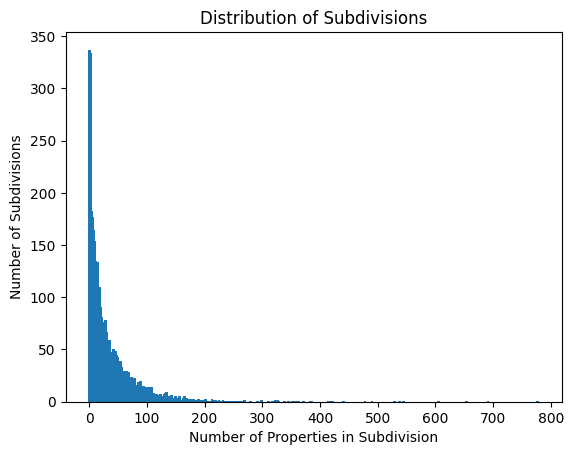

In [ ]:
x=subdivision_counts.groupby(subdivision_counts.values).size().index
y=subdivision_counts.groupby(subdivision_counts.values).size().values

plt.bar(x=x,height=y,width=5)
plt.title('Distribution of Subdivisions')
plt.xlabel('Number of Properties in Subdivision')
plt.ylabel('Number of Subdivisions')
plt.show()

In [ ]:
single_subdivisions

,count
SUBDIVISION,
DONNA'S REPLAT,1
GROVEMONT SUB'N NO. 2 YATES REPLAT,1
HUGHES - PEARSON REPLAT,1
LAKE JUDY SUB,1
MAPLE LEAF FARMS SUB,1
...,...
PORACH'S ADD NO. 3,1
"BRUNNER, E. J.",1
BAHIA VISTA 1ST ADD,1


In [ ]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['SUBDIVISION'],axis=1)

###Examining dataset and dropping rows missing values

In [ ]:
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219367 entries, 0 to 219366
Data columns (total 36 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PARCEL_NUMBER        219367 non-null  object        
 1   SITE_ADDRESS         219366 non-null  object        
 2   SITE_CITYZIP         219367 non-null  object        
 3   TOTAL_LIVING_SQFT    219367 non-null  float64       
 4   TOTAL_GROSS_SQFT     219367 non-null  float64       
 5   NBORHOOD_CD          219367 non-null  category      
 6   YEAR_BUILT_BLD1      219350 non-null  float64       
 7   TOTAL_LIVING_UNITS   219367 non-null  float64       
 8   CNTY_JST_VALUE       219367 non-null  int64         
 9   CNTY_ASD_VALUE       219367 non-null  int64         
 10  CNTY_TAXABLE_VALUE   219367 non-null  int64         
 11  SPECIAL_ASSESSMENT   219352 non-null  float64       
 12  JUST_LAND            219367 non-null  int64         
 13  JUST_BUILDING 

Looking at the dataset now, I feel like I can drop the rows that are missing any values because most of the data will remain.

In [ ]:
PCPAO_SalesDATA.dropna(inplace=True)
PCPAO_SalesDATA.reset_index(drop=True,inplace=True)
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219081 entries, 0 to 219080
Data columns (total 36 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PARCEL_NUMBER        219081 non-null  object        
 1   SITE_ADDRESS         219081 non-null  object        
 2   SITE_CITYZIP         219081 non-null  object        
 3   TOTAL_LIVING_SQFT    219081 non-null  float64       
 4   TOTAL_GROSS_SQFT     219081 non-null  float64       
 5   NBORHOOD_CD          219081 non-null  category      
 6   YEAR_BUILT_BLD1      219081 non-null  float64       
 7   TOTAL_LIVING_UNITS   219081 non-null  float64       
 8   CNTY_JST_VALUE       219081 non-null  int64         
 9   CNTY_ASD_VALUE       219081 non-null  int64         
 10  CNTY_TAXABLE_VALUE   219081 non-null  int64         
 11  SPECIAL_ASSESSMENT   219081 non-null  float64       
 12  JUST_LAND            219081 non-null  int64         
 13  JUST_BUILDING 

###Dropping Parcel Number and Site Address Columns

All the parcel numbers should be unique identifiers since we limited the records to the most recent sale of each parcel. I am not aware of any rules determining parcel numbers, so I will drop them. I will also drop the site address as I don't want to train a model to predict the housing price based on its specific address.


In [ ]:
PCPAO_SalesDATA.drop(['PARCEL_NUMBER'],axis=1,inplace=True)

In [ ]:
PCPAO_SalesDATA.drop(['SITE_ADDRESS'],axis=1,inplace=True)

###Converting Site_Cityzip and remaining object columns to categories

The SITE_CITYZIP is currently the best location identifier. There are only 86 unique cityzip combinations. Some cityzips have thousands of parcels while some cityzips have only one parcel. This is a similar situation to the subdivisions but there were never any null cityzips.

In [ ]:
PCPAO_SalesDATA['SITE_CITYZIP'].value_counts()

,count
SITE_CITYZIP,
"ST PETERSBURG, FL 33710",11519
"ST PETERSBURG, FL 33713",10055
"DUNEDIN, FL 34698",9522
"PALM HARBOR, FL 34683",9249
"ST PETERSBURG, FL 33703",8306
...,...
"TIERRA VERDE, FL 33773",1
"OLDSMAR, FL 34695",1
"INDIAN ROCKS BEACH, FL 33786",1


In [ ]:
PCPAO_SalesDATA['SITE_CITYZIP']=PCPAO_SalesDATA['SITE_CITYZIP'].astype('category')

Going to convert any remaining object types into categories.

In [ ]:
for col in PCPAO_SalesDATA.columns:
  if PCPAO_SalesDATA[col].dtype == 'object':
    PCPAO_SalesDATA[col] = PCPAO_SalesDATA[col].astype('category')

In [ ]:
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219081 entries, 0 to 219080
Data columns (total 34 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   SITE_CITYZIP         219081 non-null  category      
 1   TOTAL_LIVING_SQFT    219081 non-null  float64       
 2   TOTAL_GROSS_SQFT     219081 non-null  float64       
 3   NBORHOOD_CD          219081 non-null  category      
 4   YEAR_BUILT_BLD1      219081 non-null  float64       
 5   TOTAL_LIVING_UNITS   219081 non-null  float64       
 6   CNTY_JST_VALUE       219081 non-null  int64         
 7   CNTY_ASD_VALUE       219081 non-null  int64         
 8   CNTY_TAXABLE_VALUE   219081 non-null  int64         
 9   SPECIAL_ASSESSMENT   219081 non-null  float64       
 10  JUST_LAND            219081 non-null  int64         
 11  JUST_BUILDING        219081 non-null  int64         
 12  JUST_EXTRA_FEATURES  219081 non-null  int64         
 13  SALES_DATE    

###Dropping data that has a sales date prior to 1970.

In [ ]:
PCPAO_SalesDATA = PCPAO_SalesDATA[PCPAO_SalesDATA['SALES_DATE'].dt.year>=1970].reset_index(drop=True)

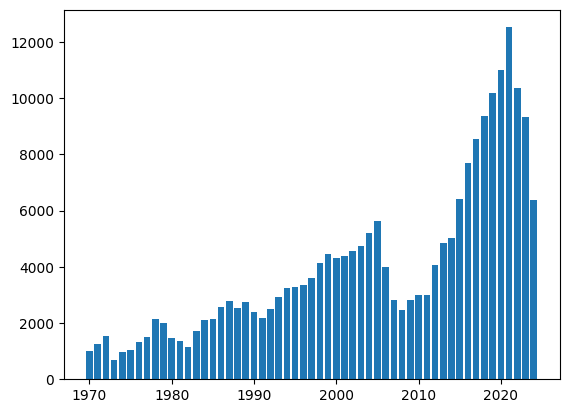

In [ ]:
sales_date_count = PCPAO_SalesDATA['SALES_DATE'].dt.year.value_counts().reset_index()
x = sales_date_count['SALES_DATE']
y = sales_date_count['count']
plt.bar(x=x,height=y)
plt.show()


This graph matches one seen in earlier data exploration. Now I will just collect sales since 2016

###Making a dataframe of data from 2016 to present

In [ ]:
sales16 = PCPAO_SalesDATA[PCPAO_SalesDATA['SALES_DATE'].dt.year>=2016].reset_index(drop=True)
sales16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85396 entries, 0 to 85395
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SITE_CITYZIP         85396 non-null  category      
 1   TOTAL_LIVING_SQFT    85396 non-null  float64       
 2   TOTAL_GROSS_SQFT     85396 non-null  float64       
 3   NBORHOOD_CD          85396 non-null  category      
 4   YEAR_BUILT_BLD1      85396 non-null  float64       
 5   TOTAL_LIVING_UNITS   85396 non-null  float64       
 6   CNTY_JST_VALUE       85396 non-null  int64         
 7   CNTY_ASD_VALUE       85396 non-null  int64         
 8   CNTY_TAXABLE_VALUE   85396 non-null  int64         
 9   SPECIAL_ASSESSMENT   85396 non-null  float64       
 10  JUST_LAND            85396 non-null  int64         
 11  JUST_BUILDING        85396 non-null  int64         
 12  JUST_EXTRA_FEATURES  85396 non-null  int64         
 13  SALES_DATE           85396 non-

In [ ]:
sales16['SALES_DATE'].dt.year.value_counts()

,count
SALES_DATE,
2021,12521
2020,11017
2022,10364
2019,10179
2018,9376
2023,9323
2017,8558
2016,7676
2024,6382


#2. Crime Data

##Assembling the files into one dataframe.

This section ends with the creation of a crime_data dataframe

I currently have the data for crimes from January 1st, 2020 to July 22nd, 2024.

I am going to start by examining one file just to get a look at the data structure

In [2]:
try:
  crime_data = pd.read_csv('/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PinellasCrimeDATA_2024/PinellasCrime20200101_20200115.csv', on_bad_lines='error')
  print('File read successfully')
except Exception as e:
  print(e)

Error tokenizing data. C error: Expected 9 fields in line 536, saw 11



Some of the csv files have errors where data in a row is recorded in an unlabeled column. I'm going to see if I can get a list of the files that have the issue, as I think these could be quick fixes. The error seems to be repeating of the city/zip in the same record.

In [3]:
error_list = []
for file in os.listdir('/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PinellasCrimeDATA_2024'):
  try:
    crime_data = pd.read_csv(f'/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PinellasCrimeDATA_2024/{file}', on_bad_lines='error')
  except Exception as e:
    error_list.append((file,e))


In [4]:
print(len(error_list))

92


In [5]:
print(error_list[0:5])

[('PinellasCrime20240516_20240531.csv', ParserError('Error tokenizing data. C error: Expected 9 fields in line 375, saw 10\n')), ('PinellasCrime20240616_20240630.csv', ParserError('Error tokenizing data. C error: Expected 9 fields in line 56, saw 11\n')), ('PinellasCrime20240301_20240315.csv', ParserError('Error tokenizing data. C error: Expected 9 fields in line 288, saw 11\n')), ('PinellasCrime20240316_20240331.csv', ParserError('Error tokenizing data. C error: Expected 9 fields in line 108, saw 10\n')), ('PinellasCrime20240601_20240615.csv', ParserError('Error tokenizing data. C error: Expected 9 fields in line 594, saw 11\n'))]


Okay, so there are 92 files with errors in 109 files. That  is more than I want to fix manually. I am going to look up methods to read in the files that have uneven lengths of records.

Some suggestions I have seen are to have a function read each line of the file to find the longest row and then use pd.read_csv with header=none, and names=range(len(longest row)).

I feel confident the longest row is a length of 11. I could just read in each file with a given set of names for the columns, skip the header row, and concatenate all of the files.

I will start by trying to just get the names of the columns.

In [6]:
data_file = '/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PinellasCrimeDATA_2024/PinellasCrime20200101_20200115.csv'
data_file_delimiter = ','
column_names = []
with open(data_file,'r') as temp_f:
  line = temp_f.readline()
  column_names = line.strip().split(data_file_delimiter)
print(column_names)

['AGENCY_ID', ' REPORT_DATE', ' OFFENSE_START_TIME', ' REPORT_KEY', ' REPORT_CODE', ' CATEGORY', ' BLOCK_ADDRESS', ' CITY', ' ZIP']


Alright, we have column names (with whitespace in some of the names). I am going to add 2 extra column names ['EXTRA_1', 'EXTRA_2'], to the column names list.

In [7]:
column_names.extend(['EXTRA_1','EXTRA_2'])

Going to strip the whitespace in the column names. It will only frustrate my typing of column later otherwise.

In [8]:
col_names = [name.strip() for name in column_names]
print(col_names)

['AGENCY_ID', 'REPORT_DATE', 'OFFENSE_START_TIME', 'REPORT_KEY', 'REPORT_CODE', 'CATEGORY', 'BLOCK_ADDRESS', 'CITY', 'ZIP', 'EXTRA_1', 'EXTRA_2']


Going to setup reading in a csv file with the new col_names.

In [9]:
crime_data = pd.read_csv(data_file,names=col_names,skiprows=1)

In [10]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1079 entries, 0 to 1078
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AGENCY_ID           1079 non-null   object 
 1   REPORT_DATE         1079 non-null   object 
 2   OFFENSE_START_TIME  1079 non-null   object 
 3   REPORT_KEY          1079 non-null   object 
 4   REPORT_CODE         1079 non-null   object 
 5   CATEGORY            1079 non-null   object 
 6   BLOCK_ADDRESS       951 non-null    object 
 7   CITY                1078 non-null   object 
 8   ZIP                 1073 non-null   float64
 9   EXTRA_1             1 non-null      object 
 10  EXTRA_2             1 non-null      float64
dtypes: float64(2), object(9)
memory usage: 92.9+ KB


In [11]:
crime_data.head(10)

,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2
0,Indian Shores PD,1/4/2020,04:51:00 PM,IS20-282,GTA,STOLEN VEHICLE,19700 Block of GULF BLVD,INDIAN SHORES,33785.0,NaN,NaN
1,Sheriff,1/6/2020,01:00:00PM,SO20-6512,PT,THEFT-PETIT,4000 Block of 54TH AVE N,PINELLAS SO,33714.0,NaN,NaN
2,Sheriff,12/31/2019,01:39:00 AM,SO20-92,AB,BATTERY-AGGRAVATED,200 Block of SCOTLAND ST,DUNEDIN,34698.0,NaN,NaN
3,Sheriff,1/2/2020,08:14:00 PM,SO20-2582,BBD,BATTERY,COUNTY JAIL,PINELLAS SO,33760.0,NaN,NaN
4,Sheriff,1/8/2020,04:40:00 PM,SO20-8930,BRGB,BURGLARY-BUSINESS,6800 Block of SEMINOLE BLVD,SEMINOLE,33772.0,NaN,NaN
5,Sheriff,1/3/2020,07:00:00 PM,SO20-3731,BRGC,BURGLARY-VEHICLE,6200 Block of SEMINOLE BLVD,SEMINOLE,33772.0,NaN,NaN
6,Sheriff,1/6/2020,11:35:00AM,SO20-6611,PT,THEFT-PETIT,7700 Block of SEMINOLE BLVD,SEMINOLE,33772.0,NaN,NaN
7,Sheriff,12/31/2019,12:00:00 PM,SO20-447,BRGC,BURGLARY-VEHICLE,10900 Block of 91ST TERR N,SEMINOLE,33772.0,NaN,NaN
8,Sheriff,12/31/2019,01:39:00 PM,SO20-468,AL,ALARM,9200 Block of SEMINOLE BLVD,SEMINOLE,33772.0,NaN,NaN
9,Sheriff,1/9/2020,01:18:00 PM,SO20-10115,BAT,BATTERY,10600 Block of BLOSSOM LAKE DR,SEMINOLE,33772.0,NaN,NaN


This is looking good. Now to work on concatenating the dataframes.

I will create a crime_data2 dataframe to join to crime_data.

In [12]:
data_file = '/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PinellasCrimeDATA_2024/PinellasCrime20200116_20200131.csv'
crime_data2 = pd.read_csv(data_file,names=col_names,skiprows=1)

In [13]:
crime_data2.info()
crime_data2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AGENCY_ID           1004 non-null   object 
 1   REPORT_DATE         1004 non-null   object 
 2   OFFENSE_START_TIME  1004 non-null   object 
 3   REPORT_KEY          1004 non-null   object 
 4   REPORT_CODE         1004 non-null   object 
 5   CATEGORY            1004 non-null   object 
 6   BLOCK_ADDRESS       987 non-null    object 
 7   CITY                1001 non-null   object 
 8   ZIP                 999 non-null    float64
 9   EXTRA_1             0 non-null      float64
 10  EXTRA_2             0 non-null      float64
dtypes: float64(3), object(8)
memory usage: 86.4+ KB


,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2
0,Sheriff,1/25/2020,08:00:00PM,SO20-27847,BRGC,BURGLARY-VEHICLE,17300 Block of GULF BLVD,N REDINGTON BEACH,33708.0,NaN,NaN
1,Sheriff,1/25/2020,02:20:00PM,SO20-26893*1,BRGR,BURGLARY-RESIDENCE,300 Block of 4TH ST S,SAFETY HARBOR,34695.0,NaN,NaN
2,Sheriff,1/25/2020,06:00:00PM,SO20-27423,GTA,STOLEN VEHICLE,WILCOX RD & WASHINGTON DR,PINELLAS SO,33774.0,NaN,NaN
3,Clearwater PD,1/25/2020,10:00:00PM,CW20-13410,PT,THEFT-PETIT,2000 Block of ALPINE RD,CLEARWATER,33755.0,NaN,NaN
4,Largo PD,1/23/2020,10:07:00PM,20000801,0680,THEFT-PETIT,601 Block of ROSERY RD NE,LARGO,33770.0,NaN,NaN


In [14]:
result = pd.concat([crime_data,crime_data2],ignore_index=True)

In [15]:
result.head()
result.info()
result.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083 entries, 0 to 2082
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AGENCY_ID           2083 non-null   object 
 1   REPORT_DATE         2083 non-null   object 
 2   OFFENSE_START_TIME  2083 non-null   object 
 3   REPORT_KEY          2083 non-null   object 
 4   REPORT_CODE         2083 non-null   object 
 5   CATEGORY            2083 non-null   object 
 6   BLOCK_ADDRESS       1938 non-null   object 
 7   CITY                2079 non-null   object 
 8   ZIP                 2072 non-null   float64
 9   EXTRA_1             1 non-null      object 
 10  EXTRA_2             1 non-null      float64
dtypes: float64(2), object(9)
memory usage: 179.1+ KB


,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2
2078,Largo PD,1/20/2020,02:30:00PM,20000669,0680,THEFT-PETIT,2600 Block of ROOSEVELT BLVD,CLEARWATER,33765.0,NaN,NaN
2079,Largo PD,1/21/2020,10:33:00PM,20000730,0810,ASSAULT,600 Block of CLEARWATER LARGO RD N,LARGO,33770.0,NaN,NaN
2080,Largo PD,1/22/2020,10:00:00PM,20000752,0710,STOLEN VEHICLE,8500 Block of ULMERTON RD,LARGO,33771.0,NaN,NaN
2081,Largo PD,1/22/2020,02:30:00PM,20000760,0810,ASSAULT,3000 Block of 19TH PL SW,LARGO,33771.0,NaN,NaN
2082,Largo PD,1/22/2020,09:09:00PM,20000767,4010,TRAFFIC ACCIDENT,ROOSEVELT BLVD/US HIGHWAY 19 N,CLEARWATER,33770.0,NaN,NaN


Putting all of this work together.

Unexpected, we have a 12th column in one of the files. Easy fix

In [16]:
col_names.append('EXTRA_3')

In [17]:
directory = '/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PinellasCrimeDATA_2024'
list_of_dfs = [pd.read_csv(f'{directory}/{file}',names=col_names,skiprows=1) for file in os.listdir(directory)]
crime_data = pd.concat(list_of_dfs,ignore_index=True)
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82599 entries, 0 to 82598
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AGENCY_ID           82599 non-null  object 
 1   REPORT_DATE         82599 non-null  object 
 2   OFFENSE_START_TIME  82599 non-null  object 
 3   REPORT_KEY          82599 non-null  object 
 4   REPORT_CODE         82599 non-null  object 
 5   CATEGORY            82599 non-null  object 
 6   BLOCK_ADDRESS       82301 non-null  object 
 7   CITY                82246 non-null  object 
 8   ZIP                 81740 non-null  object 
 9   EXTRA_1             199 non-null    object 
 10  EXTRA_2             46 non-null     object 
 11  EXTRA_3             1 non-null      float64
dtypes: float64(1), object(11)
memory usage: 7.6+ MB


##Cleaning the dataframe

M goal is to make summary statistics.


*   The total # of crimes for each city&zip combination
*   The # of crimes for each city&zip combination out of the total # of crimes in the county(effectively a percentage)
*   The # of crimes for each city
*   The # of crimes for each zip

More will be added as I make progress.



####Info from PINELLAS COUNTY SHERIFF's OFFICE
Report_key

In [18]:
crime_data.info()
crime_data.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82599 entries, 0 to 82598
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AGENCY_ID           82599 non-null  object 
 1   REPORT_DATE         82599 non-null  object 
 2   OFFENSE_START_TIME  82599 non-null  object 
 3   REPORT_KEY          82599 non-null  object 
 4   REPORT_CODE         82599 non-null  object 
 5   CATEGORY            82599 non-null  object 
 6   BLOCK_ADDRESS       82301 non-null  object 
 7   CITY                82246 non-null  object 
 8   ZIP                 81740 non-null  object 
 9   EXTRA_1             199 non-null    object 
 10  EXTRA_2             46 non-null     object 
 11  EXTRA_3             1 non-null      float64
dtypes: float64(1), object(11)
memory usage: 7.6+ MB


,0,1,2,3,4
AGENCY_ID,Sheriff,Tarpon Springs PD,Sheriff,Sheriff,Clearwater PD
REPORT_DATE,5/16/2024,5/24/2024,5/24/2024,5/24/2024,5/24/2024
OFFENSE_START_TIME,09:38:00PM,10:39:00AM,08:18:00AM,06:08:00PM,11:00:00PM
REPORT_KEY,SO24-149603,TS24-16108,SO24-159218,CW24-76282,CW24-76119
REPORT_CODE,ABR,LSAP,PT,TAWN,BRGC
CATEGORY,BURGLARY-RESIDENCE,TRAFFIC ACCIDENT,THEFT-PETIT,TRESPASS,BURGLARY-VEHICLE
BLOCK_ADDRESS,11100 Block of VALENCIA AVE,800 Block of ROOSEVELT BLVD,500 Block of SHADY GROVE DR,1200 Block of MISSOURI AVE,1100 Block of SUNSET POINT RD
CITY,SEMINOLE,TARPON SPRINGS,DUNEDIN,NaN,CLEARWATER
ZIP,33772,34689,34698,NaN,33755
EXTRA_1,NaN,NaN,NaN,NaN,NaN


First thought on cleaning the dataframe is to convert some datatypes.

CATEGORY obviously should be a category datatype.

I think REPORT_KEY might be a unique identifier column.

REPORT_DATE and OFFENSE_START_TIME should be datetime types.

AGENCY ID could be a category datatype.

ZIP should be a float/int but is an object because some CITY names are probably listed there as well


####CATEGORY column

In [19]:
crime_data['CATEGORY'].value_counts()

,count
CATEGORY,
THEFT-PETIT,14653
BATTERY,10560
BURGLARY-VEHICLE,8585
THEFT-GRAND,7444
THEFT-SHOPLIFTING,6280
TRESPASS,5088
MISSING PERSON,4644
STOLEN VEHICLE,3738
BURGLARY-RESIDENCE,3723


CATEGORY has no null values. I might want to reduce the number of categories. Maybe to [THEFTS, BURGLARY, ROBBERY, BATTERY/ASSAULT, etc.] I will see if I can get more clarification as to how to group these.

I will turn change the datatype.

In [20]:
crime_data['CATEGORY'] = crime_data['CATEGORY'].astype('category')

###REPORT_KEY, REPORT_DATE and OFFENSE_START_TIME



In [21]:
print("Number of unique 'REPORT_KEY's: ",crime_data['REPORT_KEY'].nunique())
crime_data['REPORT_KEY'].value_counts().head(10)

Number of unique 'REPORT_KEY's:  73540


,count
REPORT_KEY,
20000273,18
20000161,10
20000025,10
20000179,10
20000006,10
20000014,10
20000079,9
20000583,9
20000248,9


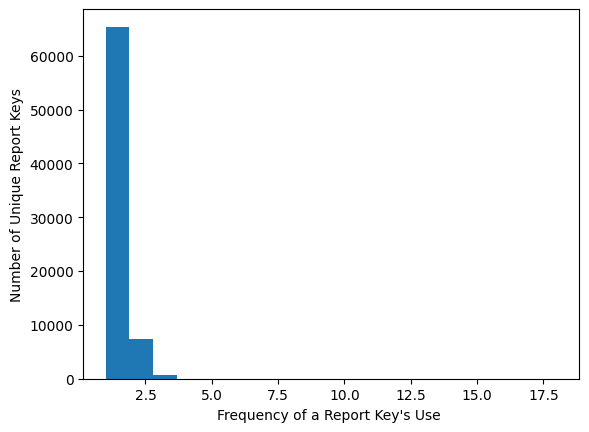

In [50]:
plt.hist(crime_data['REPORT_KEY'].value_counts().values,bins=19)
plt.xlabel("Frequency of a Report Key's Use ")
plt.ylabel('Number of Unique Report Keys')
plt.show()

In [23]:
crime_data[crime_data['REPORT_KEY']=='20000006']

,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2,EXTRA_3
81694,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
81756,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
81763,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
81764,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
81965,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
81988,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
82003,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
82211,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
82239,Largo PD,12/31/2019,03:47:00 AM,20000006,0690,THEFT-PETIT,NaN,LARGO,33771.0,NaN,NaN,NaN
82392,Largo PD,12/31/2019,03:47:00AM,20000006,0810,ASSAULT,2200 Block of EAST BAY DR,LARGO,33771.0,NaN,NaN,NaN


In [24]:
crime_data[crime_data['REPORT_KEY']=='20000273']

,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2,EXTRA_3
81717,Largo PD,1/8/2020,11:09:00 PM,20000273,0630,THEFT-SHOPLIFTING,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
81755,Largo PD,1/8/2020,11:09:00 PM,20000273,0630,THEFT-SHOPLIFTING,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
81811,Largo PD,1/8/2020,11:09:00 PM,20000273,4010,TRAFFIC ACCIDENT,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
81929,Largo PD,1/8/2020,11:09:00 PM,20000273,0630,THEFT-SHOPLIFTING,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
81979,Largo PD,1/8/2020,11:09:00 PM,20000273,4010,TRAFFIC ACCIDENT,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
82013,Largo PD,1/8/2020,11:09:00 PM,20000273,0630,THEFT-SHOPLIFTING,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
82197,Largo PD,1/8/2020,11:09:00 PM,20000273,4010,TRAFFIC ACCIDENT,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
82220,Largo PD,1/8/2020,11:09:00 PM,20000273,0630,THEFT-SHOPLIFTING,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
82231,Largo PD,1/8/2020,11:09:00 PM,20000273,4010,TRAFFIC ACCIDENT,NaN,CLEARWATER,33770.0,NaN,NaN,NaN
82233,Largo PD,1/8/2020,11:09:00 PM,20000273,4010,TRAFFIC ACCIDENT,NaN,CLEARWATER,33770.0,NaN,NaN,NaN


73540 unique report keys suggests to me that it is a identifier. Looking at records related to a report key('20000273), I see 18 records with all the same date,offense start time, agency, and location. The main difference is that 9 are coded as TRAFFIC ACCIDENT (4010) and 9 are coded as THEFT-SHOPLIFTING (0630).

I need to contact the Sheriff's Office where this information comes from to get better definitions

I might need to drop duplicates.

REPORT_DATE and OFFENSE_START_TIME should be considered datetime datatypes.

In [25]:
crime_data['REPORT_DATE'] = pd.to_datetime(crime_data['REPORT_DATE'],format='%m/%d/%Y')

REPORT_DATE was easy. OFFENSE_START_TIME has some mixed formats and strings in it.

In [26]:
crime_data['OFFENSE_START_TIME'].value_counts()

,count
OFFENSE_START_TIME,
12:00:00AM,6542
12:00:00PM,1942
Unknown,1637
05:00:00PM,1401
06:00:00PM,1385
...,...
03: 55: 00PM,1
01: 46: 00AM,1
11: 39: 00AM,1


Notice that some times have whitespace mixed into the time and AM/PM. Let's try to strip any whitespace out.

In [27]:
crime_data['OFFENSE_START_TIME']=crime_data['OFFENSE_START_TIME'].str.replace(' ',"")

In [28]:
crime_data['OFFENSE_START_TIME'].value_counts()

,count
OFFENSE_START_TIME,
12:00:00AM,6628
12:00:00PM,1980
Unknown,1637
05:00:00PM,1414
06:00:00PM,1401
...,...
04:54:00AM,4
06:47:00AM,3
06:58:00AM,3


That reduced things a little bit. Instead of 2061 unique times, there is now 1441 unique times. Still need to remove 'Unknown' so that it can be converted to 'NaT

In [29]:
crime_data.loc[crime_data['OFFENSE_START_TIME']=='Unknown','OFFENSE_START_TIME'] = np.nan
crime_data['OFFENSE_START_TIME'].value_counts()

,count
OFFENSE_START_TIME,
12:00:00AM,6628
12:00:00PM,1980
05:00:00PM,1414
06:00:00PM,1401
08:00:00PM,1356
...,...
05:41:00AM,4
06:58:00AM,3
06:47:00AM,3


Look at that number of rows! That would match to a report for every minute the day.

In [30]:
crime_data['OFFENSE_START_TIME'] = pd.to_datetime(crime_data['OFFENSE_START_TIME'],format='%I:%M:%S%p',exact=True).dt.time

I don't think keeping the OFFENSE_START_TIME information will be important in the long run.

In [31]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82599 entries, 0 to 82598
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   AGENCY_ID           82599 non-null  object        
 1   REPORT_DATE         82599 non-null  datetime64[ns]
 2   OFFENSE_START_TIME  80962 non-null  object        
 3   REPORT_KEY          82599 non-null  object        
 4   REPORT_CODE         82599 non-null  object        
 5   CATEGORY            82599 non-null  category      
 6   BLOCK_ADDRESS       82301 non-null  object        
 7   CITY                82246 non-null  object        
 8   ZIP                 81740 non-null  object        
 9   EXTRA_1             199 non-null    object        
 10  EXTRA_2             46 non-null     object        
 11  EXTRA_3             1 non-null      float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(9)
memory usage: 7.0+ MB


I want to see if there is an uneven distribustion of crime across the years. Are the records maybe only reporting weekdays or something weird like that?

In [32]:
year2020 = crime_data[crime_data['REPORT_DATE'].dt.year==2020]

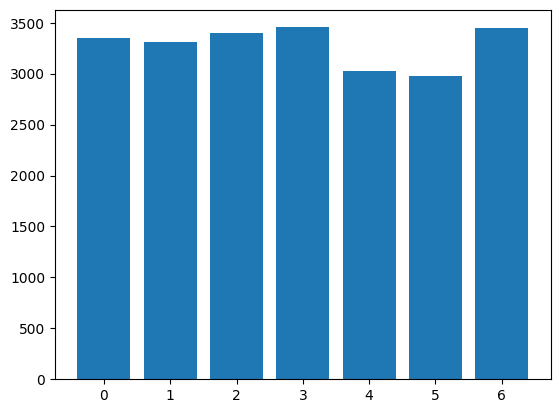

In [33]:
plt.bar(x=year2020['REPORT_DATE'].dt.day_of_week.value_counts().index,height=year2020['REPORT_DATE'].dt.day_of_week.value_counts().values)
plt.show()

For 2020, it seems that there are less crimes reported on Friday and Saturday. Is this just random? Exact days for analysis doesn't likely matter in the long run.

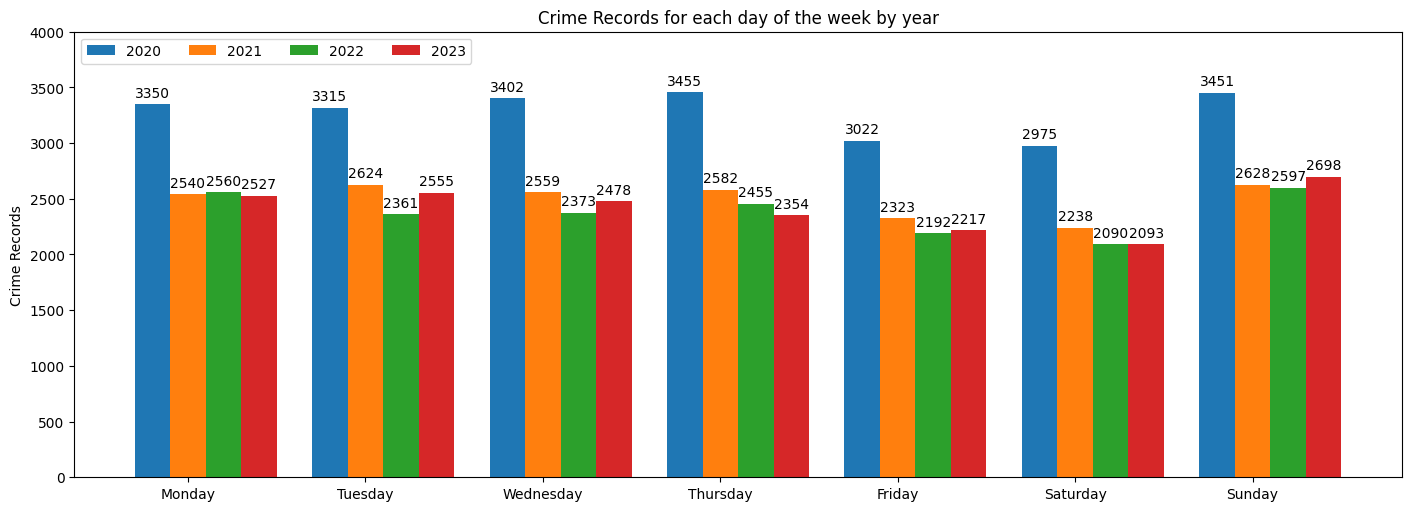

In [34]:
days_of_week = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

years = [2020,2021,2022,2023] #The list of years I will focus on here. 2024 data should be shorter because it is missing half of the year.
crime_counts = {}
for year in years:
  date_data=[]
  for date,name in days_of_week.items():
    date_data.append(crime_data[(crime_data['REPORT_DATE'].dt.year==year)&(crime_data['REPORT_DATE'].dt.day_of_week==date)].shape[0])
  crime_counts[year]=date_data

#print(crime_counts)

x = np.arange(len(days_of_week))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for year, measurement in crime_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=year)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Crime Records')
ax.set_title('Crime Records for each day of the week by year')
ax.set_xticks(x + width, days_of_week.values())
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0,4000)
fig.set_figwidth(14)
fig.set_figheight(5)
plt.show()


Okay, so there are more records of crime in 2020 than in 2021,2022,or 2023.
I will have to expand this graph in the future after I get records further back in time.

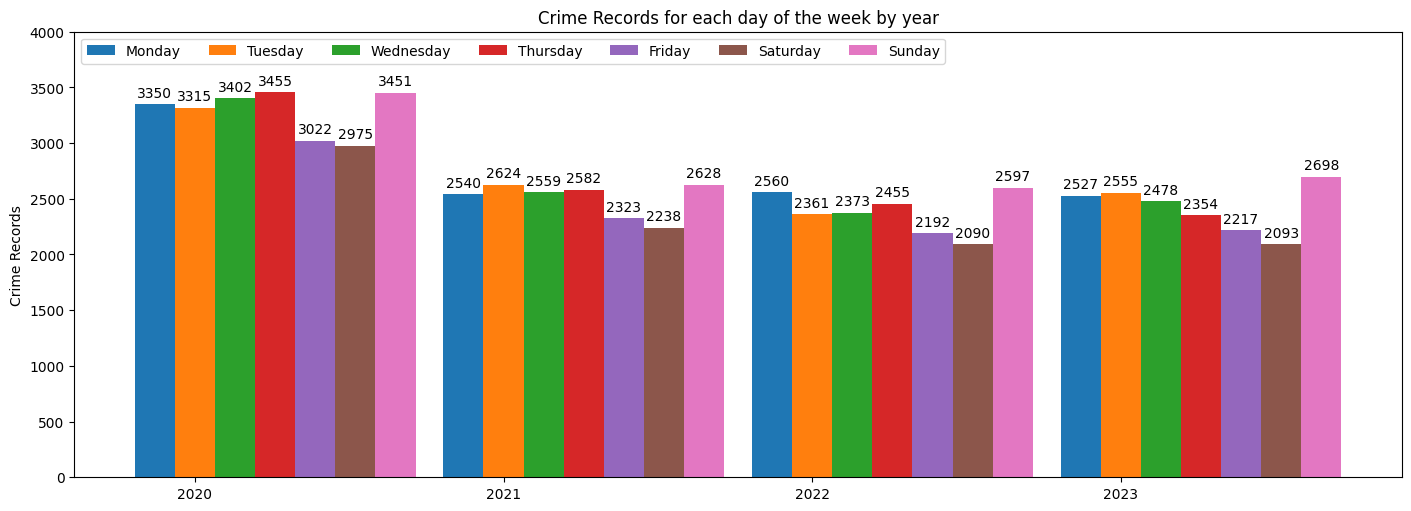

In [35]:
days_of_week = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

years = [2020,2021,2022,2023] #The list of years I will focus on here. 2024 data should be shorter because it is missing half of the year.
crime_counts = {}
for date,name in days_of_week.items():
  date_data=[]
  for year in years:
    date_data.append(crime_data[(crime_data['REPORT_DATE'].dt.year==year)&(crime_data['REPORT_DATE'].dt.day_of_week==date)].shape[0])
  crime_counts[name]=date_data

#print(crime_counts)

x = np.arange(len(years))  # the label locations
width = 0.13  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for name, measurement in crime_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=name)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Crime Records')
ax.set_title('Crime Records for each day of the week by year')
ax.set_xticks(x + width, years)
ax.legend(loc='upper left', ncols=7)
ax.set_ylim(0,4000)
fig.set_figwidth(14)
fig.set_figheight(5)
plt.show()


Seems like all of the graphs have a slight drop in crime on Friday and Saturday before spiking again on Sunday.

###CITY, ZIP and the EXTRA columns

Cleaning up the city names and zip codes. Sometimes the city name is repeated in the zip and the zip is in EXTRA_1. Sometimes there is a city in EXTRA_1 and a zip in EXTRA_2.

All the zips will need to be integers before being combined with the city in a string. This will be so that the city/zip matches the SITE_CITYZIP in the PCPAO_SalesDATA.

In [36]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82599 entries, 0 to 82598
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   AGENCY_ID           82599 non-null  object        
 1   REPORT_DATE         82599 non-null  datetime64[ns]
 2   OFFENSE_START_TIME  80962 non-null  object        
 3   REPORT_KEY          82599 non-null  object        
 4   REPORT_CODE         82599 non-null  object        
 5   CATEGORY            82599 non-null  category      
 6   BLOCK_ADDRESS       82301 non-null  object        
 7   CITY                82246 non-null  object        
 8   ZIP                 81740 non-null  object        
 9   EXTRA_1             199 non-null    object        
 10  EXTRA_2             46 non-null     object        
 11  EXTRA_3             1 non-null      float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(9)
memory usage: 7.0+ MB


The CITY and ZIP columns will be best used as string columns for now.
I will strip the columns of whitespace to make them easier to compare(hopefully).

EXTRA_1 and EXTRA_2 need the same treatment.

I don't want to convert np.nan into 'nan' so, I will filter to only focus on not-na values.

In [37]:
#Some of the CITY column values have whitespace.
#Converting all of the non-NaN values in EXTRA_1 & EXTRA_2 columns to strings and stripping of whitespace as well
crime_data['CITY']=crime_data[crime_data['CITY'].notna()]['CITY'].astype(str).str.strip()
crime_data['ZIP']=crime_data[crime_data['ZIP'].notna()]['ZIP'].astype(str).str.strip()
crime_data['EXTRA_1']=crime_data[crime_data['EXTRA_1'].notna()]['EXTRA_1'].astype(str).str.strip()
crime_data['EXTRA_2']=crime_data[crime_data['EXTRA_2'].notna()]['EXTRA_2'].astype(str).str.strip()

In [38]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82599 entries, 0 to 82598
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   AGENCY_ID           82599 non-null  object        
 1   REPORT_DATE         82599 non-null  datetime64[ns]
 2   OFFENSE_START_TIME  80962 non-null  object        
 3   REPORT_KEY          82599 non-null  object        
 4   REPORT_CODE         82599 non-null  object        
 5   CATEGORY            82599 non-null  category      
 6   BLOCK_ADDRESS       82301 non-null  object        
 7   CITY                82246 non-null  object        
 8   ZIP                 81740 non-null  object        
 9   EXTRA_1             199 non-null    object        
 10  EXTRA_2             46 non-null     object        
 11  EXTRA_3             1 non-null      float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(9)
memory usage: 7.0+ MB


###Going to start by examining/fixing the one row that has a value in EXTRA_3

In [39]:
crime_data[crime_data['EXTRA_3'].notna()]

,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2,EXTRA_3
76784,Sheriff,2020-03-24,21:30:00,so20-92195,PT,THEFT-PETIT,8300 Block of BAYOU BOARDWALK,APT 801,SEMINOLE,,PINELLAS SO,33777.0


EXTRA_1 is null, EXTRA_2 is Pinellas SO(I think this means pinesllas sheriff's office), and EXTRA_3 is the zip code.
CITY is the apartment number while ZIP is the CITY. I just need to adjust some of these.
I will make the CITY=SEMINOLE and the ZIP=33777. I will make extra_1,extra_2, and extra_3 null.

WHAT IS THAT OFFENSE_START_TIME ??? It has a date and military time. NOT what I expect to see there.

In [40]:
crime_data.iloc[76784,crime_data.columns.get_loc('ZIP')] = 33777
crime_data.iloc[76784,crime_data.columns.get_loc('CITY')] = 'SEMINOLE'
crime_data.iloc[76784,crime_data.columns.get_loc('EXTRA_1')] = np.nan
crime_data.iloc[76784,crime_data.columns.get_loc('EXTRA_2')] = np.nan
crime_data.iloc[76784,crime_data.columns.get_loc('EXTRA_3')] = np.nan
crime_data.iloc[76784,:]

,76784
AGENCY_ID,Sheriff
REPORT_DATE,2020-03-24 00:00:00
OFFENSE_START_TIME,21:30:00
REPORT_KEY,so20-92195
REPORT_CODE,PT
CATEGORY,THEFT-PETIT
BLOCK_ADDRESS,8300 Block of BAYOU BOARDWALK
CITY,SEMINOLE
ZIP,33777
EXTRA_1,NaN


In [41]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82599 entries, 0 to 82598
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   AGENCY_ID           82599 non-null  object        
 1   REPORT_DATE         82599 non-null  datetime64[ns]
 2   OFFENSE_START_TIME  80962 non-null  object        
 3   REPORT_KEY          82599 non-null  object        
 4   REPORT_CODE         82599 non-null  object        
 5   CATEGORY            82599 non-null  category      
 6   BLOCK_ADDRESS       82301 non-null  object        
 7   CITY                82246 non-null  object        
 8   ZIP                 81740 non-null  object        
 9   EXTRA_1             198 non-null    object        
 10  EXTRA_2             45 non-null     object        
 11  EXTRA_3             0 non-null      float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(9)
memory usage: 7.0+ MB


EXTRA_3 is now all null. Perfect to drop and then inspect rows with non-null EXTRA_2 columns.


###Working on columns with non-null EXTRA_2

In [42]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82599 entries, 0 to 82598
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   AGENCY_ID           82599 non-null  object        
 1   REPORT_DATE         82599 non-null  datetime64[ns]
 2   OFFENSE_START_TIME  80962 non-null  object        
 3   REPORT_KEY          82599 non-null  object        
 4   REPORT_CODE         82599 non-null  object        
 5   CATEGORY            82599 non-null  category      
 6   BLOCK_ADDRESS       82301 non-null  object        
 7   CITY                82246 non-null  object        
 8   ZIP                 81740 non-null  object        
 9   EXTRA_1             198 non-null    object        
 10  EXTRA_2             45 non-null     object        
 11  EXTRA_3             0 non-null      float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(9)
memory usage: 7.0+ MB


In [43]:
crime_data.drop(['EXTRA_3'],axis=1,inplace=True)

####Cleaning process.
* Examine the first value that is non-na in the EXTRA_2 column
* Identify a feature to select on that gets the first value(not index value)
* Target the feature to see what other records come up.
* If all the records targeted have the same problem, fix the problem in the #Make Changes cell
* If all the records don't have the same problem, narrow the target some more.
* Record all changes that are done in the #Make Changes cell in the #Record Changes Here Cell
* Repeat process with EXTRA_1 column

In [44]:
crime_data[crime_data['EXTRA_1'].notna()]

,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2
373,Sheriff,2024-05-16,17:30:00,SO24-150505,CMF,VANDAL/CRIM MISCH,500 Block of ALT 19,UNINCORPORATED,PINELLAS SO,34698.0,NaN
609,Tarpon Springs PD,2024-05-28,12:16:00,TS24-16609,LSAP,TRAFFIC ACCIDENT,ALT 19 & E TARPON AVE,TARPON SPRINGS,TARPON SPRINGS,34689.0,NaN
1384,Sheriff,2024-06-22,21:37:00,SO24-192824,PT,THEFT-PETIT,700 Block of ALT 19,PALM HARBOR,34683.0,PINELLAS SO,34683.0
1680,Sheriff,2024-06-22,21:37:00,SO24-192824,PT,THEFT-PETIT,700 Block of ALT 19,PALM HARBOR,34683.0,PINELLAS SO,34683.0
2269,Tarpon Springs PD,2024-03-10,10:29:00,TS24-7817,LSAP,TRAFFIC ACCIDENT,ALT 19 & MERES BLVD,TARPON SPRINGS,346.0,TARPON SPRINGS,34689.0
...,...,...,...,...,...,...,...,...,...,...,...
78290,Sheriff,2020-02-29,23:20:00,SO20-67718,LSAI,TRAFFIC ACCIDENT,ALT 19 & PALM BLVD,DUNEDIN,DUNEDIN,34698,NaN
79106,Sheriff,2020-02-27,00:00:00,SO20-65349,GT,THEFT-GRAND,1060 Block of PINELLAS BAYWAY S,ST PETERSBURG,ST PETERSBURG,33715.0,NaN
80062,Sheriff,2020-02-05,18:42:00,SO20-41119,GT,THEFT-GRAND,3200 Block of PINELLAS BAYWAY S,ST PETERSBURG,ST PETERSBURG,33715.0,NaN
80390,Sheriff,2020-02-10,18:25:00,SO20-46641,LSWU,TRAFFIC ACCIDENT,1000 Block of BROADWAY,DUNEDIN,DUNEDIN,34698.0,NaN


I am going to have to tailor some of these fixes. I will make all the fixes in indiviual codes. I will then copy the fixing codes into a designated cell that can be run when going through the notebook.

In [45]:
#See what is being targeted here
#for example:
crime_data[crime_data['EXTRA_1']=='33765']

,AGENCY_ID,REPORT_DATE,OFFENSE_START_TIME,REPORT_KEY,REPORT_CODE,CATEGORY,BLOCK_ADDRESS,CITY,ZIP,EXTRA_1,EXTRA_2
73880,Clearwater PD,2020-05-15,NaT,CW20-71031,LSAP,TRAFFIC ACCIDENT,GULF TO BAY BLVD & BYPASS DR,CLEARWATER,CLEARWATER,33765,NaN


In [46]:
#make changes here
#The record here has '33765' in EXTRA_1.
#CITY will stay CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33765
temp_index = crime_data[crime_data['EXTRA_1']=='33765'].index
crime_data.loc[temp_index,'ZIP']='33765'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan


####EXTRA_2 fixes

Running this will run a set of data cleaning to a make the EXTRA_2 column all null values. Other values like CITY, ZIP, and EXTRA_1 will be cleaned some as well.

**Only valid for data from JAN 1st, 2020 to JULY 22nd, 2024.**

**When data prior to 2020 is included, this will need to be fixed up again**

In [47]:
#Record the changes here.
#If the CITY column and EXTRA_1 column match, then the EXTRA_1 column can be set to np.nan
temp_index = crime_data[crime_data['CITY']==crime_data['EXTRA_1']]
crime_data.loc[temp_index.index,'EXTRA_1']=np.nan

#If ZIP matches EXTRA_2, then the extra_2 can be np.nan
temp_index = crime_data[crime_data['EXTRA_2']==crime_data['ZIP']].index
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#Fixing zip codes and clearing extra_2 in Tarpon Springs
temp_index = crime_data[crime_data['EXTRA_2']=='34689.0'].index
crime_data.loc[temp_index,'ZIP']='34689'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#Dunedin locations with EXTRA_2=34698.0 have correct city, zip.
#EXTRA values are cleared out.
temp_index = crime_data[crime_data['EXTRA_2']=='34698.0'].index
crime_data.loc[temp_index,'ZIP']='34698'
crime_data.loc[temp_index,'CITY']='DUNEDIN'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#CROSSING OF COURTNEY CAMPBELL CSWY
temp_index = crime_data[crime_data['BLOCK_ADDRESS']=='COURTNEY CAMPBELL CSWY'].index
crime_data.loc[temp_index,'ZIP']='33759'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#This set has UNINCORPORATED and PALM HARBOR for CITY values
#The ZIP 34683 matches EXTRA_2. Need to clearout the EXTRA columns
temp_index = crime_data[(crime_data['ZIP']=='34683')&(crime_data['EXTRA_2']=='34683.0')].index
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#This location needed ZIP added from EXTRA_2
#Need to clearout the EXTRA columns
temp_index = crime_data[crime_data['EXTRA_2']=='33773.0'].index
crime_data.loc[temp_index,'ZIP']='33773'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#CITY and ZIP look fine
#Need to clearout the EXTRA columns
temp_index = crime_data[crime_data['EXTRA_2']=='33764.0'].index
crime_data.loc[temp_index,'ZIP']='33764'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#BLOCK_ADDRESS, CITY, ZIP all agree
#Clearing EXTRAs
temp_index = crime_data[crime_data['EXTRA_2']=='33767.0'].index
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#This set of data had ZIPs in the EXTRA columns and was mixing CITY names
#CITY name TIERRA VERDE instead of ST PETERSBURG
temp_index = crime_data[crime_data['EXTRA_2']=='33715.0'].index
crime_data.loc[temp_index,'ZIP']='33715'
crime_data.loc[temp_index,'CITY']='TIERRA VERDE'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#This BLOCK ADDRESS gives a ST PETERSBURG city
#and 33707 ZIP value.
temp_index = crime_data[crime_data['EXTRA_2']=='33707.0'].index
crime_data.loc[temp_index,'ZIP']='33707'
crime_data.loc[temp_index,'CITY']='ST PETERSBURG'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#This temp_index focused on TARPON SPRINGS
#The addresses straddle the line between Tarpon Springs and Palm Harbor
#Going to go with Tarpon Springs as the CITY and ZIP already match address-wise
#ZIP needed fixing on one record. EXTRAs needed clearing
temp_index = crime_data[(crime_data['EXTRA_2']=='34683.0')&(crime_data['CITY']=='TARPON SPRINGS')].index
crime_data.loc[temp_index,'ZIP']='34689'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#Two Madeira Beach records were missing ZIP and had them in EXTRA_2
temp_index = crime_data[crime_data['EXTRA_2']=='33708.0'].index
crime_data.loc[temp_index,'ZIP']='33708'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#Treasure Island BLOCK_ADDRESS, CITY and ZIP line up
#Clear the EXTRAs
temp_index = crime_data[crime_data['EXTRA_2']=='33706.0'].index
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#This record has CLEARWATER BEACH as block_address
#CLEARWATER as CITY and AVENUE as ZIP
#Treating this as being on CLEARWATER BEACH
temp_index = crime_data[crime_data['EXTRA_2']=='33759.0'].index
crime_data.loc[temp_index,'ZIP']='33767'
crime_data.loc[temp_index,'CITY']='CLEARWATER BEACH'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#This UNINCORPORATED record would have PALM HARBOR as the CITY
#Then the ZIP in EXTRA_2 would make sense
temp_index = crime_data[(crime_data['EXTRA_2']=='34683.0')&(crime_data['CITY']=='UNINCORPORATED')].index
crime_data.loc[temp_index,'ZIP']='34683'
crime_data.loc[temp_index,'CITY']='PALM HARBOR'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan


crime_data.drop(['EXTRA_2'],axis=1,inplace=True)

####EXTRA_1 Fixes
After all of the EXTRA_2 column is NaN,
 work to make all the EXTRA_1 column NaN

In [48]:
#Recording fixes for EXTRA_1 Here

#The records here all have the ZIP in EXTRA_1
#Almost every single ZIP and CITY is DUNEDIN
#Then a couple are UNINCORPORATED and PINELLAS SO
temp_index = crime_data[crime_data['EXTRA_1']=='34698.0'].index
crime_data.loc[temp_index,'ZIP']='34698'
crime_data.loc[temp_index,'CITY']='DUNEDIN'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have the ZIP in EXTRA_1
#Almost every single CITY and ZIP is TARPON SPRINGS
#Then a couple are TARPON SPRINGS and PINELLAS SO
temp_index = crime_data[crime_data['EXTRA_1']=='34689.0'].index
crime_data.loc[temp_index,'ZIP']='34689'
crime_data.loc[temp_index,'CITY']='TARPON SPRINGS'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have PINELLAS SO in EXTRA_1
#Almost every single CITY is PALM HARBOR
#A couple CITY values are UNINCORPORATED, which will get replaced by PALM HARBOR
#ZIPs need to be fixed to not have '.0'
temp_index = crime_data[crime_data['EXTRA_1']=='PINELLAS SO'].index
crime_data.loc[temp_index,'ZIP']='34683'
crime_data.loc[temp_index,'CITY']='PALM HARBOR'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33764.0' in EXTRA_1
#Every single CITY is CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33764
temp_index = crime_data[crime_data['EXTRA_1']=='33764.0'].index
crime_data.loc[temp_index,'ZIP']='33764'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '34689' in EXTRA_1
#Every single CITY is TARPON SPRINGS
#ZIPs need to be fixed from TARPON SPRINGS to 34689
temp_index = crime_data[crime_data['EXTRA_1']=='34689'].index
crime_data.loc[temp_index,'ZIP']='34689'
crime_data.loc[temp_index,'CITY']='TARPON SPRINGS'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33715.0' in EXTRA_1
#Every single CITY is ST PETERSBURG
#ZIPs need to be fixed from ST PETERSBURG to 33715
temp_index = crime_data[crime_data['EXTRA_1']=='33715.0'].index
crime_data.loc[temp_index,'ZIP']='33715'
crime_data.loc[temp_index,'CITY']='ST PETERSBURG'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33708.0' in EXTRA_1
#CITY needs to be fixed from MADEIRA to MADEIRA BEACH
#ZIPs need to be fixed from MADEIRA BEACH to 33708
temp_index = crime_data[crime_data['EXTRA_1']=='33708.0'].index
crime_data.loc[temp_index,'ZIP']='33708'
crime_data.loc[temp_index,'CITY']='MADEIRA BEACH'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '34683.0' in EXTRA_1
#CITY needs to be fixed from UNINCORPORATED to PALM HARBOR
#ZIPs need to be fixed from PINELLAS SO to 34683
temp_index = crime_data[crime_data['EXTRA_1']=='34683.0'].index
crime_data.loc[temp_index,'ZIP']='34683'
crime_data.loc[temp_index,'CITY']='PALM HARBOR'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '34677.0' in EXTRA_1
#CITY needs to be fixed from FL to OLDSMAR
#ZIPs need to be fixed from OLDSMAR to 34677
temp_index = crime_data[crime_data['EXTRA_1']=='34677.0'].index
crime_data.loc[temp_index,'ZIP']='34677'
crime_data.loc[temp_index,'CITY']='OLDSMAR'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '34698' in EXTRA_1
#A CITY record needs to be fixed from UNINCORPORATED to DUNEDIN
#ZIPs need to be fixed from DUNEDIN to 34698
temp_index = crime_data[crime_data['EXTRA_1']=='34698'].index
crime_data.loc[temp_index,'ZIP']='34698'
crime_data.loc[temp_index,'CITY']='DUNEDIN'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33715' in EXTRA_1
#ZIPs need to be fixed from ST PETERSBURG to 33715
temp_index = crime_data[(crime_data['EXTRA_1']=='33715')&(crime_data['CITY']=='ST PETERSBURG')].index
crime_data.loc[temp_index,'ZIP']='33715'
crime_data.loc[temp_index,'CITY']='ST PETERSBURG'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '34683' in EXTRA_1
#CITY is UNINCORPORATED. Will change to PALM HARBOR
#ZIPs need to be fixed from PINELLAS SO to 34683
temp_index = crime_data[crime_data['EXTRA_1']=='34683'].index
crime_data.loc[temp_index,'ZIP']='34683'
crime_data.loc[temp_index,'CITY']='PALM HARBOR'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33715' in EXTRA_1
#CITY is UNIN. Will change to TIERRA VERDE
#ZIPs need to be fixed from PINELLAS SO to 33715
temp_index = crime_data[crime_data['EXTRA_1']=='33715'].index
crime_data.loc[temp_index,'ZIP']='33715'
crime_data.loc[temp_index,'CITY']='TIERRA VERDE'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33761.0' in EXTRA_1
#CITY is CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33761
temp_index = crime_data[crime_data['EXTRA_1']=='33761.0'].index
crime_data.loc[temp_index,'ZIP']='33761'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33707.0' in EXTRA_1
#CITY is blank. Will fix to GULFPORT
#ZIPs need to be fixed from GULFPORT to 33707
temp_index = crime_data[(crime_data['EXTRA_1']=='33707.0')&(crime_data['ZIP']=='GULFPORT')].index
crime_data.loc[temp_index,'ZIP']='33707'
crime_data.loc[temp_index,'CITY']='GULFPORT'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33707.0' in EXTRA_1
#CITY is SOUTH PASADENA
#ZIPs need to be fixed from SOUTH PASADENA to 33707
temp_index = crime_data[(crime_data['EXTRA_1']=='33707.0')&(crime_data['ZIP']=='SOUTH PASADENA')].index
crime_data.loc[temp_index,'ZIP']='33707'
crime_data.loc[temp_index,'CITY']='SOUTH PASADENA'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33756' in EXTRA_1
#CITYs need to be fixed from FL to CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33756
temp_index = crime_data[crime_data['EXTRA_1']=='33756'].index
crime_data.loc[temp_index,'ZIP']='33756'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33755.0' in EXTRA_1
#CITY is CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33755
temp_index = crime_data[crime_data['EXTRA_1']=='33755.0'].index
crime_data.loc[temp_index,'ZIP']='33755'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33710.0' in EXTRA_1
#CITY is ST PETERSBURG
#ZIPs need to be fixed from ST PETERSBURG to 33710
temp_index = crime_data[crime_data['EXTRA_1']=='33710.0'].index
crime_data.loc[temp_index,'ZIP']='33710'
crime_data.loc[temp_index,'CITY']='ST PETERSBURG'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33763.0' in EXTRA_1
#CITY needs to be fixed from blank to CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33763
temp_index = crime_data[crime_data['EXTRA_1']=='33763.0'].index
crime_data.loc[temp_index,'ZIP']='33763'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33707' in EXTRA_1 & SOUTH PASADENA in ZIP
#CITY is SOUTH PASADENA
#ZIPs need to be fixed from SOUTH PASADENA to 33707
temp_index = crime_data[(crime_data['EXTRA_1']=='33707')&(crime_data['ZIP']=='SOUTH PASADENA')].index
crime_data.loc[temp_index,'ZIP']='33707'
crime_data.loc[temp_index,'CITY']='SOUTH PASADENA'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The records here all have '33706.0' in EXTRA_1
#CITY needs to be fixed from 100 BLK 107TH AVE to TREASURE ISLAND
#ZIPs need to be fixed from TREASURE ISLAND to 33706
temp_index = crime_data[crime_data['EXTRA_1']=='33706.0'].index
crime_data.loc[temp_index,'ZIP']='33706'
crime_data.loc[temp_index,'CITY']='TREASURE ISLAND'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The two records here all have '33755' in EXTRA_1.
#CITY will stay DUNEDIN
#ZIPs need to be fixed from CLEARWATER and DUNEDIN to 33755
temp_index = crime_data[crime_data['EXTRA_1']=='33755'].index
crime_data.loc[temp_index,'ZIP']='33755'
crime_data.loc[temp_index,'CITY']='DUNEDIN'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The two records here all have '33764' in EXTRA_1.
#CITY will stay CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33764
temp_index = crime_data[crime_data['EXTRA_1']=='33764'].index
crime_data.loc[temp_index,'ZIP']='33764'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The two records here all have '33707' in EXTRA_1.
#CITY needs to be fixed from blank to GULFPORT
#ZIPs need to be fixed from GULFPORT to 33707
temp_index = crime_data[crime_data['EXTRA_1']=='33707'].index
crime_data.loc[temp_index,'ZIP']='33707'
crime_data.loc[temp_index,'CITY']='GULFPORT'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

#The record here has '33765' in EXTRA_1.
#CITY will stay CLEARWATER
#ZIPs need to be fixed from CLEARWATER to 33765
temp_index = crime_data[crime_data['EXTRA_1']=='33765'].index
crime_data.loc[temp_index,'ZIP']='33765'
crime_data.loc[temp_index,'CITY']='CLEARWATER'
crime_data.loc[temp_index,'EXTRA_1']=np.nan
crime_data.loc[temp_index,'EXTRA_2']=np.nan

crime_data.drop(['EXTRA_1'],axis=1,inplace=True)


#4. Exporting Data

Here I will export the cleaned data for the PCPAO_SalesDATA and for sales16 into their own csv files.

In [ ]:
PCPAO_SalesDATA.to_csv('/content/drive/MyDrive/Data Science Course/Capstone Work/Cleaned_Data/PCPAO_SalesDATA_cleaned.csv',index=False)


In [ ]:
sales16.to_csv('/content/drive/MyDrive/Data Science Course/Capstone Work/Cleaned_Data/sales16_cleaned.csv',index=False)